# Code for analyzing volume output
- Uses cortical thickness data CSVs (../results/FreeSurfer) generated by "../scripts/freesurfer_surface_measures.sh" script using aparcstats2table utility from [FreeSurfer pipeline](http://surfer.nmr.mgh.harvard.edu/fswiki/FreeSurferAnalysisPipelineOverview)
- Uses participants data (../metadata/) for inclusion/exclusion criteria and demographic info
## Cohorts
- Normal Controls, Essential Tremor, Parkinsons
## Parcellations
- DKT
- Distreux
## Covariates
- Age, Sex
- TBV (doesn't really make sense - but still checked)

In [1]:
import pandas as pd
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import nibabel as nib

sys.path.append('../')
from lib.stats_utils import *

In [2]:
project_dir = '../../../'
data_dir = project_dir + 'data/preproc_T1s/'
metadata_dir = '../metadata/'
results_dir = '../results/FreeSurfer/'

In [3]:
participant_df = pd.read_csv('{}participants.csv'.format(metadata_dir))

# exclusions
exclude_subjects = list(participant_df[participant_df['Include in analysis']==0]['Participant_id'])
exclude_subjects = exclude_subjects + ['sub-0123'] # Age unknow ['?']

participant_df = participant_df[~participant_df['Participant_id'].isin(exclude_subjects)]
include_subjects = participant_df['Participant_id'].values
print('Total number of participants included: {} (excluded: {})'.format(len(include_subjects),len(exclude_subjects)))

# reformat columns
participant_df['Age'] = participant_df['Age'].astype(np.int)
age_df = participant_df.groupby(['group','Sex'])[['Age']].mean()
sex_df = participant_df.groupby(['group','Sex']).count()['Participant_id']

print(pd.merge(age_df,sex_df,on=['group','Sex']))

participant_df.head()

Total number of participants included: 113 (excluded: 22)
                 Age  Participant_id
group Sex                           
ET    F    72.600000              10
      M    73.678571              28
NC    F    58.636364              11
      M    55.095238              21
PD    F    62.375000              16
      M    62.259259              27


,Participant_id,Age,Sex,group,Include in analysis,conversion Problem,opteration,T1w,T2w,dwi,...,bold fmap,swi,fmriprep (ses-1) anat only,freesurfer-6.0.1,fmriprep (ses-1) anat + bold prprocessing,T1-QC,T1-template,SUIT () cerebellum segmentation,MAGeT processing,MAGet Comments
0,sub-0002,70,M,PD,1,"no rs-bold, only 4 protocols",1,1,1,1,...,0,0,1,1,"no bold, no res",2,NaN,1,1,NaN
1,sub-0004,76,F,PD,1,1,1,1,1,1,...,NaN,0,1,1,NaN,3,NaN,R2,1,NaN
2,sub-0005,45,M,PD,1,0,1,1,1,1,...,0,20,1,1,NaN,4,NaN,1,1,NaN
3,sub-0006,63,F,PD,1,0,1,1,1,1,...,0,10,1,1,NaN,3,NaN,1,1,NaN
4,sub-0008,59,M,PD,1,"no bold and no dwi, no localizer, only 2 proto...",1,1,1,0,...,0,0,1,1,NaN,4,NaN,1,1,NaN


In [4]:
demograph_columns = ['Participant_id',	'Age',	'Sex',	'group']

analysis_df = participant_df[demograph_columns]
print('Total number of participants in the analysis: {})'.format(len(analysis_df)))
analysis_df.head()

Total number of participants in the analysis: 113)


,Participant_id,Age,Sex,group
0,sub-0002,70,M,PD
1,sub-0004,76,F,PD
2,sub-0005,45,M,PD
3,sub-0006,63,F,PD
4,sub-0008,59,M,PD


### Grab cortical thickness

In [5]:
atlas = 'DKT' #'Destrieux' #'DKT'
groups = ['NC','ET']
hemispheres = ['lh','rh']
CT_df_concat = pd.DataFrame()
for group in groups:
    for hemi in hemispheres:
        CT_csv = '{}{}/{}_CT.{}_{}.csv'.format(results_dir,group,group,atlas,hemi)
        CT_df = pd.read_csv(CT_csv,delim_whitespace=True)

        # rename columns to cocat multiple cohorts / hemis
        orig_columns = list(CT_df.columns)
        print('Number of ROIs: {}'.format(len(orig_columns)))
        if atlas == 'DKT':
            renamed_columns = ['Participant_id'] + [c.split('_')[1] for c in orig_columns[1:]]
        else:
            renamed_columns = ['Participant_id'] + [c.split('_',1)[1].rsplit('_',1)[0].replace('&', '_and_').replace('-', '_') for c in orig_columns[1:]]
        
        CT_df = CT_df.rename(columns=dict(zip(orig_columns,renamed_columns)))
        CT_df[['group','hemi']] = [group,hemi] 
        CT_df_concat = CT_df_concat.append(CT_df)

# ROI cols
roi_cols = renamed_columns[1:-1]

# filter included subjects from participants demographics
CT_df_concat = CT_df_concat[CT_df_concat['Participant_id'].isin(include_subjects)]

# sort and count group sizes
CT_df_concat = CT_df_concat.sort_values(['group','Participant_id'])
group_sizes = CT_df_concat[CT_df_concat['hemi']=='lh'].value_counts(['group'])
print('Number of Participant_ids:\n{}'.format(group_sizes))

h_lines = np.cumsum(group_sizes.sort_index().values)[:-1]
v_lines = len(orig_columns[1:])

print('hlines: {}, vlines: {}'.format(h_lines,v_lines))


# Drop temporal anomaly (this columns is present only in rh for NC subjects)
if 'temporalpole' in CT_df_concat.columns:
    CT_df_concat = CT_df_concat.drop(columns=['temporalpole'])

Number of ROIs: 33
Number of ROIs: 34
Number of ROIs: 33
Number of ROIs: 33
Number of Participant_ids:
group
ET       38
NC       32
dtype: int64
hlines: [38], vlines: 32


## Plots
### Average CTs: Individuals

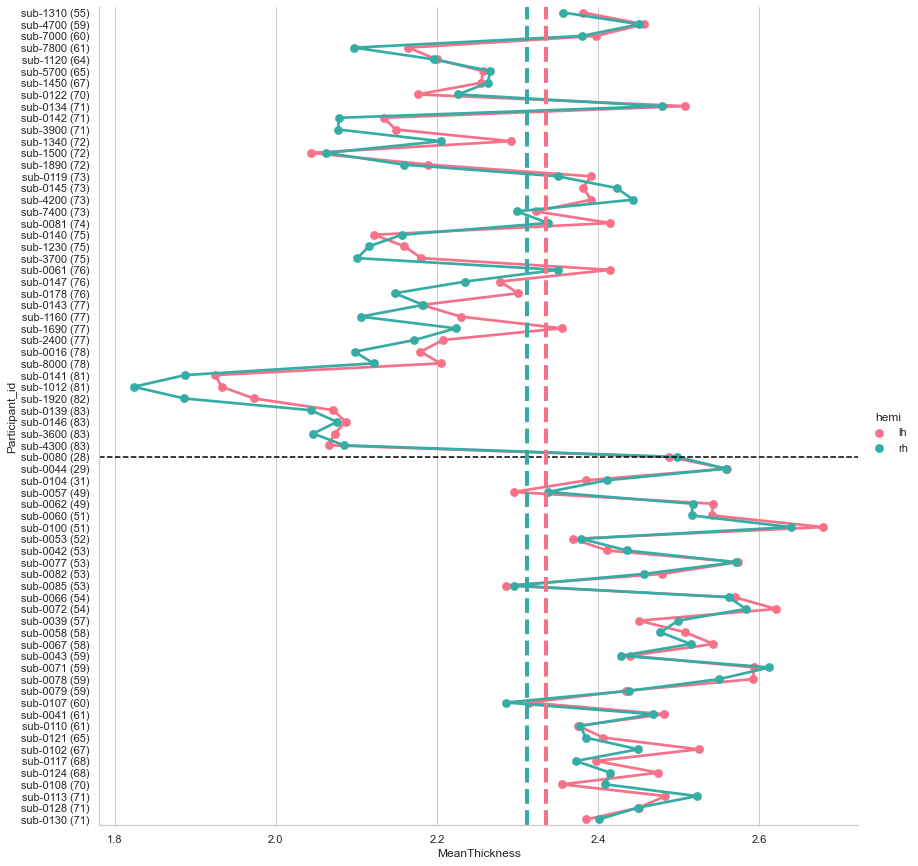

In [6]:
plot_df = CT_df_concat.copy()
plot_df = plot_df[['Participant_id','group','hemi','MeanThickness']]
plot_df = pd.merge(plot_df,participant_df[['Participant_id','Age']], on = 'Participant_id')
plot_df = plot_df.sort_values(['group','Age'])
plot_df['Participant_id'] = plot_df['Participant_id'] + ' (' + plot_df['Age'].astype(str) + ')'

vol_min = np.min(plot_df[['MeanThickness']].values)
vol_max = np.max(plot_df[['MeanThickness']].values)
L_CT_mean = np.mean(plot_df[plot_df['hemi']=='lh']['MeanThickness'].values)
R_CT_mean = np.mean(plot_df[plot_df['hemi']=='rh']['MeanThickness'].values)

palette = sns.color_palette('husl',2)

sns.set(font_scale=1)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x='MeanThickness', y='Participant_id', hue='hemi', kind='point',aspect=1, height=12, palette = palette,
                    data=plot_df)

    for h_line in h_lines:
        plt.axhline(h_line, ls='--',c='black')

    plt.axvline(L_CT_mean, ls='--',lw=4, c=palette[0])
    plt.axvline(R_CT_mean, ls='--',lw=4, c=palette[1])
    # g.set_xticklabels(rotation=50)
    

### Group comparisons

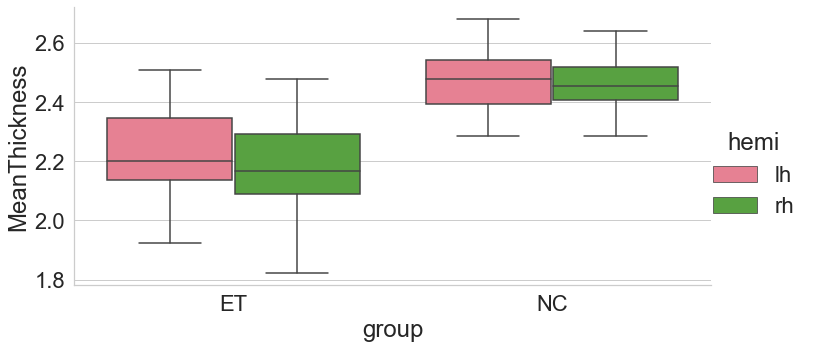

In [7]:
sns.set(font_scale=2)
palette = sns.color_palette('husl',3)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y='MeanThickness', x='group', hue='hemi', kind='box',aspect=2, height=5, palette = palette,
                    data=plot_df)

### ROI thickness

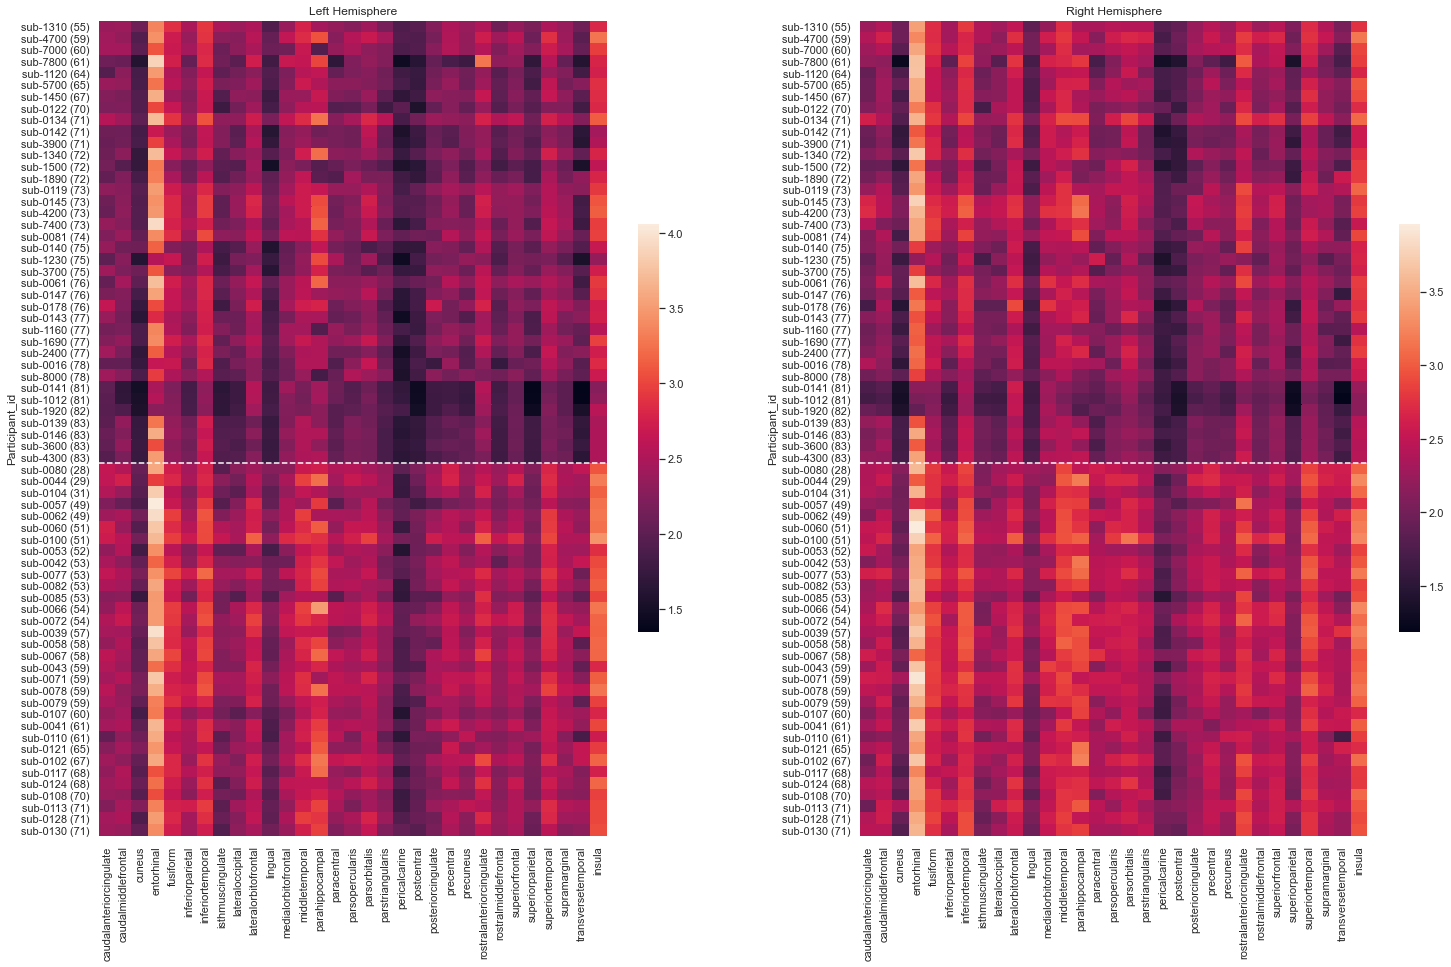

In [8]:
plot_df = CT_df_concat.copy()
plot_df = pd.merge(plot_df,participant_df[['Participant_id','Age']], on = 'Participant_id')
plot_df = plot_df.sort_values(['group','Age'])
plot_df['Participant_id'] = plot_df['Participant_id'] + ' (' + plot_df['Age'].astype(str) + ')'
plot_df = plot_df.set_index('Participant_id')

sns.set(font_scale=1)
with sns.axes_style("white"):
    f, axes = plt.subplots(1,2,figsize=(25, 15))
    ax = axes[0]
    plot_df_lh = plot_df[plot_df['hemi']=='lh'][roi_cols]
    g = sns.heatmap(plot_df_lh,cbar_kws={"shrink": .5}, ax=ax)
    ax.set_title('Left Hemisphere')
    for h_line in h_lines:
        ax.axhline(h_line, ls='--',c='white')

    ax = axes[1]
    plot_df_rh = plot_df[plot_df['hemi']=='rh'][roi_cols]
    g = sns.heatmap(plot_df_rh,cbar_kws={"shrink": .5}, ax=ax)
    ax.set_title('Right Hemisphere')
    for h_line in h_lines:
        ax.axhline(h_line, ls='--',c='white')


### Group comparisons

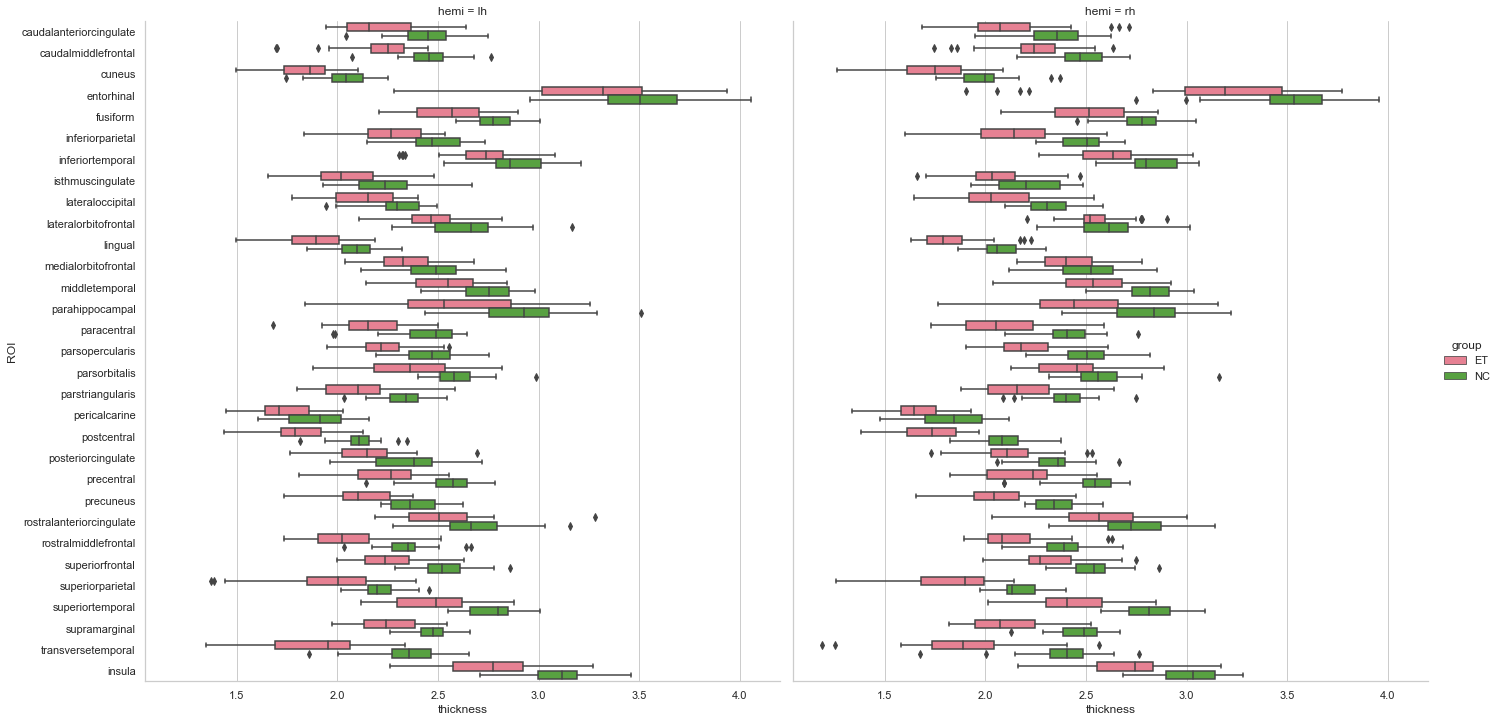

In [9]:
plot_df = CT_df_concat.copy()
plot_df = plot_df[['Participant_id','group','hemi'] + roi_cols]

palette = sns.color_palette('husl',3)
with sns.axes_style("whitegrid"):
    plot_df = pd.melt(plot_df, id_vars = ['Participant_id','group','hemi'], value_vars = roi_cols, 
                      var_name ='ROI', value_name ='thickness')
    g = sns.catplot(x='thickness', y='ROI', hue='group', col='hemi', kind='box',aspect=1, height=10, palette=palette,
                    data=plot_df)

 

## OLS

In [10]:
stat_df_lh_rh = pd.merge(CT_df_concat,analysis_df,on=['Participant_id','group'],how='inner')
print('Total number of participants in the analysis after volume_df ({}) + demo_df ({}) merge : {}'.format(len(CT_df_concat),len(analysis_df),len(stat_df_lh_rh)))
group_sizes = stat_df_lh_rh[stat_df_lh_rh['hemi']=='lh'].value_counts(['group'])
print('Number of Participant_ids:\n{}'.format(group_sizes))

stat_cols = roi_cols + ['MeanThickness','Age']

stat_df_lh_rh[stat_cols] = stat_df_lh_rh[stat_cols].astype(float)

# regression (# check model with Age only)
independent_var = 'C(group, Treatment(reference=\'NC\'))' #'Age'
compare_levels =  ['C(group, Treatment(reference=\'NC\'))[T.ET]'] #,'C(group, Treatment(reference=\'NC\'))[T.PD]'] #'Age'
covars = 'Age + C(Sex)' #'brain_volume + C(Sex)' 

# OLS result df
res_df_concat = pd.DataFrame()
for hemi in hemispheres:
    stat_df = stat_df_lh_rh[stat_df_lh_rh['hemi']==hemi]

    for dependent_var in roi_cols + ['MeanThickness']:
        res = smf.ols(formula='{} ~ {} + {}'.format(dependent_var, covars, independent_var), data=stat_df).fit()
        res_df = format_ols_results(res)
        res_df['dependent_var'] = dependent_var
        res_df['hemi'] = hemi
        res_df_concat = res_df_concat.append(res_df)

res_df_concat.head()

Total number of participants in the analysis after volume_df (140) + demo_df (113) merge : 140
Number of Participant_ids:
group
ET       38
NC       32
dtype: int64


,index,coef,std err,t,P>|t|,[0.025,0.975],R2,R2_adj,dependent_var,hemi
0,Intercept,2.8870,0.128,22.508,0.000,2.631,3.143,0.443877,0.418599,caudalanteriorcingulate,lh
1,C(Sex)[T.M],-0.0371,0.042,-0.884,0.380,-0.121,0.047,0.443877,0.418599,caudalanteriorcingulate,lh
2,"C(group, Treatment(reference='NC'))[T.ET]",-0.1135,0.053,-2.133,0.037,-0.220,-0.007,0.443877,0.418599,caudalanteriorcingulate,lh
3,Age,-0.0074,0.002,-3.468,0.001,-0.012,-0.003,0.443877,0.418599,caudalanteriorcingulate,lh
0,Intercept,2.7642,0.119,23.319,0.000,2.528,3.001,0.446728,0.421579,caudalmiddlefrontal,lh


## Plots

Using corrected p-val threshold of 0.0008
signficant ROIs: [('paracentral', 'lh'), ('postcentral', 'lh'), ('precuneus', 'lh'), ('rostralmiddlefrontal', 'lh'), ('superiorfrontal', 'lh'), ('transversetemporal', 'lh'), ('MeanThickness', 'lh'), ('inferiorparietal', 'rh'), ('paracentral', 'rh'), ('postcentral', 'rh'), ('precuneus', 'rh'), ('superiorparietal', 'rh'), ('superiortemporal', 'rh'), ('supramarginal', 'rh'), ('transversetemporal', 'rh'), ('MeanThickness', 'rh')]


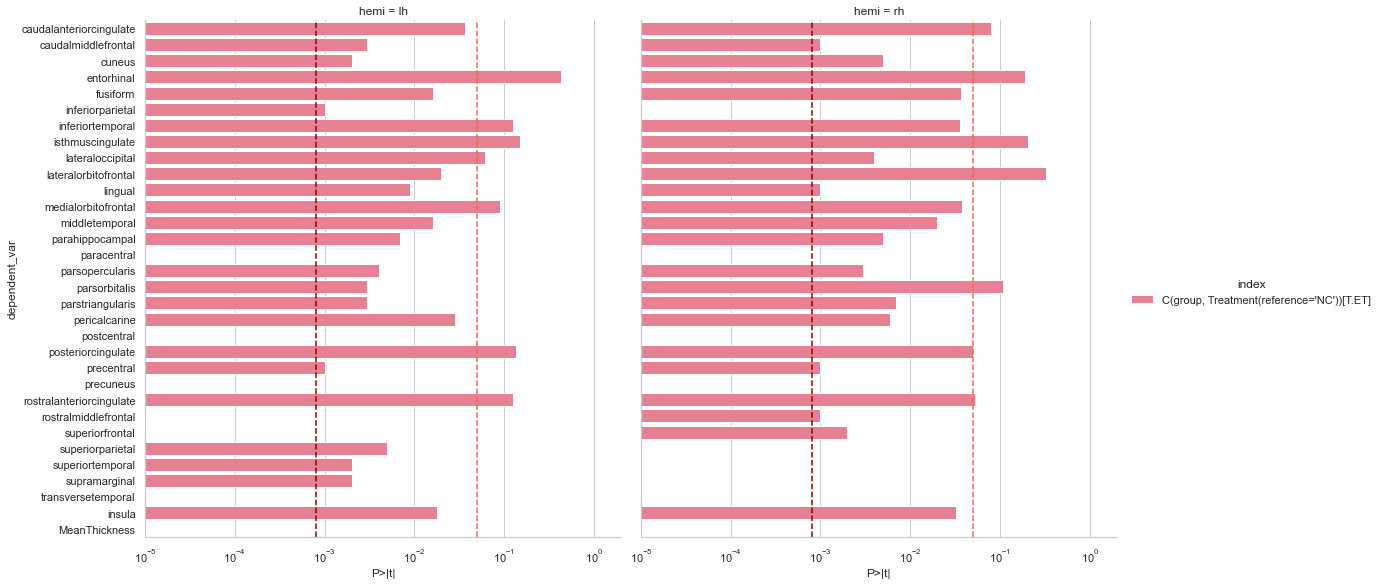

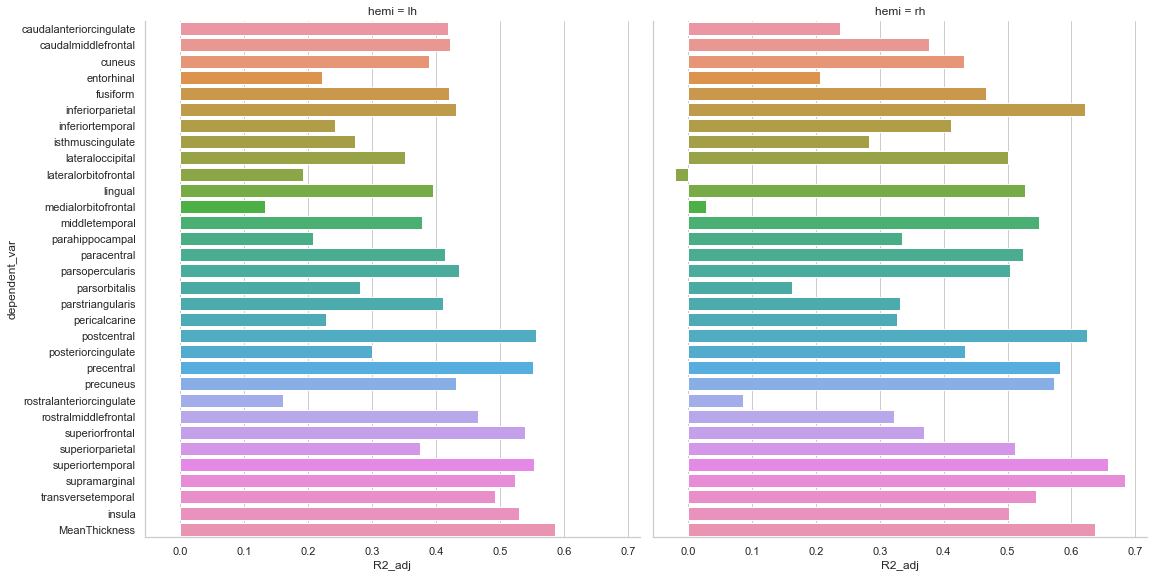

In [11]:
plot_df = res_df_concat[res_df_concat['index'].isin(compare_levels)].copy()
n_compare = 2*len(roi_cols) 
signific_thesh = 0.05/(n_compare)
print('Using corrected p-val threshold of {:5.4f}'.format(signific_thesh))

signific_ROIs = plot_df[plot_df['P>|t|'] < signific_thesh]['dependent_var'].values
signific_hemis = plot_df[plot_df['P>|t|'] < signific_thesh]['hemi'].values

print('signficant ROIs: {}'.format(list(zip(signific_ROIs,signific_hemis))))

with sns.axes_style("whitegrid"):
    g = sns.catplot(x='P>|t|', y='dependent_var', kind='bar', hue='index', col='hemi', aspect=1, height=8, palette=palette,
                    data=plot_df)
    g.set(xscale='log',xlim=(1e-5,2))
    for ax in g.axes.flat:
        ax.axvline(0.05, ls='--',c='tomato')
        ax.axvline(signific_thesh, ls='--',c='darkred')

with sns.axes_style("whitegrid"):
    g = sns.catplot(x='R2_adj', y='dependent_var', col='hemi', kind='bar', aspect=1, height=8,
                    data=plot_df)

In [12]:
signific_df = res_df_concat[res_df_concat['dependent_var'].isin(signific_ROIs)]
signific_df

,index,coef,std err,t,P>|t|,[0.025,0.975],R2,R2_adj,dependent_var,hemi
0,Intercept,2.7180,0.122,22.269,0.000,2.474,2.962,0.456641,0.431943,inferiorparietal,lh
1,C(Sex)[T.M],-0.1587,0.040,-3.979,0.000,-0.238,-0.079,0.456641,0.431943,inferiorparietal,lh
2,"C(group, Treatment(reference='NC'))[T.ET]",-0.1760,0.051,-3.477,0.001,-0.277,-0.075,0.456641,0.431943,inferiorparietal,lh
3,Age,-0.0023,0.002,-1.113,0.270,-0.006,0.002,0.456641,0.431943,inferiorparietal,lh
0,Intercept,2.5558,0.135,18.925,0.000,2.286,2.825,0.440182,0.414736,paracentral,lh
...,...,...,...,...,...,...,...,...,...,...,...
3,Age,-0.0082,0.003,-2.633,0.011,-0.014,-0.002,0.563999,0.544181,transversetemporal,rh
0,Intercept,2.8382,0.092,30.896,0.000,2.655,3.022,0.653152,0.637386,MeanThickness,rh
1,C(Sex)[T.M],-0.0913,0.030,-3.041,0.003,-0.151,-0.031,0.653152,0.637386,MeanThickness,rh
2,"C(group, Treatment(reference='NC'))[T.ET]",-0.1756,0.038,-4.609,0.000,-0.252,-0.100,0.653152,0.637386,MeanThickness,rh
